In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

image_folder1 = r'C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUT-OMRON-image\DUT-OMRON-image'
saliency_folder1 = r'C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\DUT-OMRON-gt-pixelwise.zip\pixelwiseGT-new-PNG'

image_folder2 = r'C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\images\images'
saliency_folder2 = r'C:\Users\JAYADITHYA\OneDrive\Documents\Sahithi Research Internship\ground_truth_mask\ground_truth_mask'

image_paths1 = glob.glob(os.path.join(image_folder1, '*.jpg'))
saliency_paths1 = glob.glob(os.path.join(saliency_folder1, '*.png'))

image_paths2 = glob.glob(os.path.join(image_folder2, '*.jpg'))
saliency_paths2 = glob.glob(os.path.join(saliency_folder2, '*.png'))

print("Total DUT-OMRON dataset size for images:", len(image_paths1))
print("Total DUT-OMRON dataset size for saliency maps:", len(saliency_paths1))

print("Total ECSSD dataset size for images:", len(image_paths2))
print("Total ECSSD dataset size for saliency maps:", len(saliency_paths2))


Total DUT-OMRON dataset size for images: 5168
Total DUT-OMRON dataset size for saliency maps: 5168
Total ECSSD dataset size for images: 1000
Total ECSSD dataset size for saliency maps: 1000


In [ ]:
train_images1, test_images1, train_saliency1, test_saliency1 = train_test_split(image_paths1, saliency_paths1, test_size=0.2, random_state=42)
train_images1, validation_images1, train_saliency1, validation_saliency1 = train_test_split(train_images1, train_saliency1, test_size=0.25, random_state=42)

train_images2, test_images2, train_saliency2, test_saliency2 = train_test_split(image_paths2, saliency_paths2, test_size=0.2, random_state=42)
train_images2, validation_images2, train_saliency2, validation_saliency2 = train_test_split(train_images2, train_saliency2, test_size=0.25, random_state=42)

train_images = train_images1
train_saliency = train_saliency1

validation_images = validation_images1
validation_saliency = validation_saliency1

test_images = test_images2
test_saliency = test_saliency2

print("DUT-OMRON Training set size:", len(train_images1))
print("DUT-OMRON Validation set size:", len(validation_images1))
print("DUT-OMRON Testing set size:", len(test_images1))

print("\nECSSD Training set size:", len(train_images2))
print("ECSSD Validation set size:", len(validation_images2))
print("ECSSD Testing set size:", len(test_images2))

print("\nOur model Training set size:", len(train_images))
print("Our model Validation set size:", len(validation_images))
print("Our model Testing set size:", len(test_images))



DUT-OMRON Training set size: 3100
DUT-OMRON Validation set size: 1034
DUT-OMRON Testing set size: 1034

ECSSD Training set size: 600
ECSSD Validation set size: 200
ECSSD Testing set size: 200

Our model Training set size: 3100
Our model Validation set size: 1034
Our model Testing set size: 200


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

def create_cnn_model():
    stream1= tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
    ])

    stream2 = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.MaxPooling2D((2, 2)),
    ])

    fusion = layers.Concatenate()([stream1.output, stream2.output])

    additional_layers = layers.Conv2D(1, (1, 1), activation='sigmoid')(fusion)
    additional_layers = tf.image.resize(additional_layers, (111, 111))

    model = models.Model(inputs=[stream1.input, stream2.input], outputs=additional_layers)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    loss_fn = tf.keras.losses.BinaryCrossentropy()
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss_fn)

    return model, learning_rate_reduction, early_stopping


In [ ]:
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    return image

def preprocess_saliency(saliency_path):
    saliency = tf.keras.preprocessing.image.load_img(saliency_path, target_size=(111, 111), color_mode='grayscale')
    saliency = tf.keras.preprocessing.image.img_to_array(saliency)
    saliency = saliency / 255.0
    return saliency


def load_data(image_paths, saliency_paths):

    images = []
    saliency_maps = []

    for image_path, saliency_path in zip(image_paths, saliency_paths):

        image = preprocess_image(image_path)
        saliency = preprocess_saliency(saliency_path)

        images.append(image)
        saliency_maps.append(saliency)

    images = np.array(images)
    saliency_maps = np.array(saliency_maps)

    return images, saliency_maps

In [ ]:
train_images, train_saliency = load_data(train_images, train_saliency)

validation_images, validation_saliency = load_data(validation_images, validation_saliency)

test_images, test_saliency = load_data(test_images, test_saliency)

In [ ]:
cnn_model, learning_rate_reduction, early_stopping = create_cnn_model()
epochs = 40
batch_size = 32

history = cnn_model.fit([train_images, train_images], train_saliency, batch_size=batch_size, epochs=epochs,
                            validation_data=([validation_images, validation_images], validation_saliency),
                            callbacks=[learning_rate_reduction, early_stopping])


Epoch 1/40
97/97 [==============================] - 190s 2s/step - loss: 0.5461 - val_loss: 0.5083 - lr: 0.0100
Epoch 2/40
97/97 [==============================] - 158s 2s/step - loss: 0.4881 - val_loss: 0.4758 - lr: 0.0100
Epoch 3/40
97/97 [==============================] - 160s 2s/step - loss: 0.4621 - val_loss: 0.4558 - lr: 0.0100
Epoch 4/40
97/97 [==============================] - 156s 2s/step - loss: 0.4455 - val_loss: 0.4428 - lr: 0.0100
Epoch 5/40
97/97 [==============================] - 161s 2s/step - loss: 0.4347 - val_loss: 0.4348 - lr: 0.0100
Epoch 6/40
97/97 [==============================] - 158s 2s/step - loss: 0.4277 - val_loss: 0.4284 - lr: 0.0100
Epoch 7/40
97/97 [==============================] - 160s 2s/step - loss: 0.4228 - val_loss: 0.4247 - lr: 0.0100
Epoch 8/40
97/97 [==============================] - 159s 2s/step - loss: 0.4198 - val_loss: 0.4222 - lr: 0.0100
Epoch 9/40
97/97 [==============================] - 158s 2s/step - loss: 0.4175 - val_loss: 0.4202 - lr:

In [ ]:
test_loss = cnn_model.evaluate([test_images, test_images], test_saliency)
print("Test loss:", test_loss)

predictions = cnn_model.predict([test_images, test_images])

def calculate_accuracy(y_true, y_pred):

    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_binary.flatten()

    accuracy = np.mean(np.equal(y_true_flat, y_pred_flat))
    return accuracy

test_accuracy = calculate_accuracy(test_saliency, predictions)
print("Test accuracy:", test_accuracy)

7/7 [==============================] - 3s 391ms/step - loss: 0.5512
Test loss: 0.5511643886566162
7/7 [==============================] - 3s 355ms/step
Test accuracy: 0.76575805535265


In [ ]:
cnn_model.save('40_32_0.01_DUT-OMRON_ECSSD.h5')

In [ ]:
def calculate_precision_recall_fmeasure(y_true, y_pred):

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    y_pred_binary = np.where(y_pred_flat >= 0.1622, 1, 0)

    # Calculate True Positives, False Positives, False Negatives
    tp = np.sum((y_true_flat == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true_flat == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_flat == 1) & (y_pred_binary == 0))

    print("True Positives:", tp)
    print("False Positives:", fp)
    print("False Negatives:", fn)

    # Calculate precision, recall, and F-measure
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f_measure = 2 * (precision * recall) / (precision + recall + 1e-9)

    return precision, recall, f_measure

precision, recall, f_measure = calculate_precision_recall_fmeasure(test_saliency, predictions)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)


True Positives: 323946
False Positives: 597062
False Negatives: 255034
Precision: 0.35172984382328887
Recall: 0.5595115548032737
F-measure: 0.43193145497763974


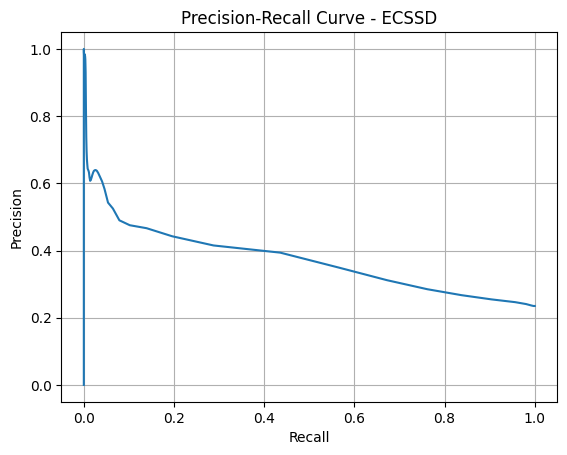

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_precision_recall(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(np.uint8)

    tp = np.sum((y_true == 1) & (y_pred_binary == 1))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))

    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)

    return precision, recall

thresholds = np.linspace(0, 1, num=100)

precisions = []
recalls = []

for threshold in thresholds:
    precision, recall = calculate_precision_recall(test_saliency, predictions, threshold)
    precisions.append(precision)
    recalls.append(recall)

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - ECSSD')
plt.grid(True)
plt.show()


In [ ]:
def save_model_weights(model, filename):
    model.save_weights(filename)

def load_model_weights(model, filename):
    model.load_weights(filename)

save_model_weights(cnn_model, '40_32_0.01_DUT-OMRON_ECSSD_after_40_epochs.h5')

epochs_to_resume = 60

load_model_weights(cnn_model, '40_32_0.01_DUT-OMRON_ECSSD_after_40_epochs.h5')

history = cnn_model.fit(
    [train_images, train_images], train_saliency, batch_size=batch_size, epochs=epochs_to_resume - epochs,
    validation_data=([validation_images, validation_images], validation_saliency),
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/20
97/97 [==============================] - 166s 2s/step - loss: 0.4100 - val_loss: 0.4127 - lr: 6.2500e-04
Epoch 2/20
97/97 [==============================] - 166s 2s/step - loss: 0.4100 - val_loss: 0.4127 - lr: 6.2500e-04
Epoch 3/20
97/97 [==============================] - ETA: 0s - loss: 0.4100
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
97/97 [==============================] - 167s 2s/step - loss: 0.4100 - val_loss: 0.4127 - lr: 6.2500e-04
Epoch 4/20
97/97 [==============================] - 170s 2s/step - loss: 0.4099 - val_loss: 0.4127 - lr: 3.1250e-04
Epoch 5/20
97/97 [==============================] - ETA: 0s - loss: 0.4099
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
97/97 [==============================] - 166s 2s/step - loss: 0.4099 - val_loss: 0.4127 - lr: 3.1250e-04
Epoch 6/20
97/97 [==============================] - 169s 2s/step - loss: 0.4099 - val_loss: 0.4127 - lr: 1.5625e-04
Epoch 7/20
97/97 [=====

In [ ]:
test_loss = cnn_model.evaluate([test_images, test_images], test_saliency)
print("Test loss:", test_loss)

predictions = cnn_model.predict([test_images, test_images])

def calculate_accuracy(y_true, y_pred):

    y_pred_binary = np.where(y_pred >= 0.5, 1, 0)

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_binary.flatten()

    accuracy = np.mean(np.equal(y_true_flat, y_pred_flat))
    return accuracy

test_accuracy = calculate_accuracy(test_saliency, predictions)
print("Test accuracy:", test_accuracy)

7/7 [==============================] - 3s 392ms/step - loss: 0.5514
Test loss: 0.5514143109321594
7/7 [==============================] - 3s 381ms/step
Test accuracy: 0.7657649541433326


In [ ]:
save_model_weights(cnn_model, '60_32_0.01_DUT-OMRON_ECSSD_after_60_epochs.h5')

cnn_model.save('60_32_0.01_DUT-OMRON_ECSSD.h5')